<a href="https://colab.research.google.com/github/Himika-Mishra/Dissertation/blob/main/Mnist_Type_2_(Case_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Type 2 (Case 2)

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tqdm import tqdm
import random
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse as sp
from sklearn.metrics import f1_score

In [2]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filter images and labels for digits 0 to 6
mask_train = np.isin(y_train, [0, 1, 2, 3, 4, 5, 6])
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Reshape the images to 784-dimensional vectors
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255
X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255

# Create separate instances of OneHotEncoder for training and testing sets
encoder_train = OneHotEncoder(categories=[range(10)])
encoder_test = OneHotEncoder(categories=[range(10)])

# Fit the encoders on the respective datasets
encoder_train.fit(y_train.reshape((-1, 1)))
encoder_test.fit(y_test.reshape((-1, 1)))

# Transform the labels in the training set
y_train_encoded = encoder_train.transform(y_train.reshape((-1, 1))).toarray()

# Transform the labels in the testing set
y_test_encoded = encoder_test.transform(y_test.reshape((-1, 1))).toarray()

11490434/11490434 [==============================] - 0s 0us/step


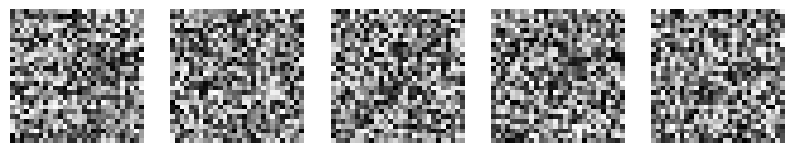

In [3]:
# Generate random noise images
noise_images = np.random.uniform(low=0.0, high=1.0, size=(1000000, 784))

# Plot random 5 noise images
random_indices = np.random.choice(len(noise_images), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, index in enumerate(random_indices):
    noise_image = noise_images[index].reshape(28, 28)
    axes[i].imshow(noise_image, cmap='gray')
    axes[i].axis('off')

plt.show()

In [4]:
# Create a dataframe to store the noisy images
x_train_distorted = pd.DataFrame(noise_images)

In [5]:
# Create a dataframe of array of zeroes as labels for above distorted images
y_train_distorted = np.zeros((1000000, 10))

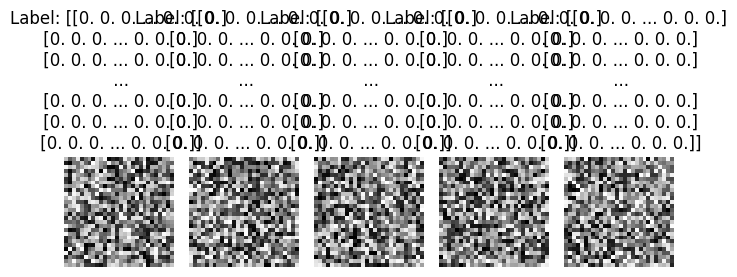

In [6]:
# Select 5 random indices
random_indices = random.sample(range(len(x_train_distorted)), 5)

# Retrieve the distorted images and labels at the selected indices
distorted_images = [noise_images[i] for i in random_indices]
labels = [y_train_distorted for i in random_indices]

# Display the random images
for i in range(5):
    image = distorted_images[i]
    label = labels[i]
    
    # Reshape the image back to its original shape (assuming it was flattened)
    image = image.reshape(28, 28)
    
    # Plot the image
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [7]:
# Initialize the merged train dataframe
merged_x_train = pd.DataFrame()

In [8]:
# Define the ratio of distorted images to select
ratios = np.arange(0.1, 1.1, 0.1)

In [9]:
# Convert the distorted train data from list and ndarray to DataFrame
x_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train_encoded)
x_train_distorted = pd.DataFrame(x_train_distorted)
y_train_distorted = pd.DataFrame(y_train_distorted)

In [10]:
# Create a DataFrame with uniform distributed noise
np.random.seed(42)

# Initialize lists to store the ratio and F1 scores
ratios = []
f1_scores = []
classification_reports = []

# Define the range for reducing the training set
start_ratio = 0.1
end_ratio = 1.1
increment = 0.1

# Train and evaluate the model 
# Fit a regular MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train, y_train)
# Accuracy Score
test_acc = mlp.score(x_train, y_train)
# print(mlp.score(x_train, y_train))
print(f"Test accuracy with original data(0-9) with original_ratio= 0.0: {test_acc}")

# predictions
pred = mlp.predict(X_test)
print(confusion_matrix(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))
print(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))

# Calculate F1 score and store the ratio, F1 score, and classification report
f1 = f1_score(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), average='weighted')
ratios.append(0.0)
f1_scores.append(f1)
classification_reports.append(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), output_dict=True))

# Iterate over the ratios
for ratio in np.arange(start_ratio, end_ratio, increment):
    # Calculate the number of distorted images to select based on the ratio
    num_distorted = int(len(x_train) * ratio)

    # Randomly select the specified number of distorted images
    selected_distorted_images = x_train_distorted.sample(n=num_distorted, random_state=42)
    selected_distorted_labels = y_train_distorted.sample(n=num_distorted, random_state=42)

    # Create a noise DataFrame with the same number of rows as reduced training set
    noise_data = pd.DataFrame(np.random.uniform(size=(num_distorted, 784)))
    noise_labels = np.zeros((num_distorted, 10))

    # Concatenate the selected distorted images with the original train dataframe
    merged_x_train = np.concatenate([x_train, noise_data.values])
    merged_y_train = np.concatenate([y_train, noise_labels])

    # Train and evaluate the model 
    # Fit a regular MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
    mlp.fit(merged_x_train, merged_y_train)
    # Accuracy Score
    test_acc = mlp.score(merged_x_train, merged_y_train)
    # print(mlp.score(merged_x_train, merged_y_train))
    print(f"Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio={ratio}: {test_acc}")

    # predictions
    pred = mlp.predict(X_test)
    print(confusion_matrix(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))
    print(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))

    # Calculate F1 score and store the ratio, F1 score, and classification report
    f1 = f1_score(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), average='weighted')
    ratios.append(ratio)
    f1_scores.append(f1)
    classification_reports.append(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), output_dict=True))
    print("--------------------------------------------------")

Test accuracy with original data(0-9) with original_ratio= 0.0: 0.9879098604983904
[[ 962    0    8    1    1    4    4    0    0    0]
 [   5 1118    6    2    1    1    2    0    0    0]
 [  16    6  966   36    6    0    2    0    0    0]
 [  17    4   18  955    0   15    1    0    0    0]
 [  17    0    3    7  944    3    8    0    0    0]
 [  43    1    3   30   13  794    8    0    0    0]
 [  29    2    6    0    8   11  902    0    0    0]
 [ 211   33  158  411  145   70    0    0    0    0]
 [ 197   90   90  384   35  152   26    0    0    0]
 [ 154   15   23  149  554  113    1    0    0    0]]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       980
           1       0.88      0.99      0.93      1135
           2       0.75      0.94      0.84      1032
           3       0.48      0.95      0.64      1010
           4       0.55      0.96      0.70       982
           5       0.68      0.89      0.77       892
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.1: 0.9812044745057232
[[ 967    0    2    1    3    3    4    0    0    0]
 [   8 1116    3    4    1    1    2    0    0    0]
 [  31    9  955   18    9    2    8    0    0    0]
 [  23    1   21  952    3    8    2    0    0    0]
 [  10    1    6    5  949    0   11    0    0    0]
 [  47    4    2   19   10  801    9    0    0    0]
 [  27    3    7    0    8   11  902    0    0    0]
 [ 250   60  123  304  192   99    0    0    0    0]
 [ 267   57   58  361   66  135   30    0    0    0]
 [  89   13    3   86  782   36    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.56      0.99      0.72       980
           1       0.88      0.98      0.93      1135
           2       0.81      0.93      0.86      1032
           3       0.54      0.94      0.69      1010
           4       0.47      0.97      0.63       982
           5       0.73     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.2: 0.9845793092484401
[[ 970    0    3    2    2    1    2    0    0    0]
 [   7 1114   10    2    1    0    1    0    0    0]
 [  26    7  963   13   10    3   10    0    0    0]
 [  22    4   14  948    1   19    2    0    0    0]
 [  10    2   14    3  943    4    6    0    0    0]
 [  20    1    1   34    8  816   12    0    0    0]
 [  25    2    8    1   10   15  897    0    0    0]
 [ 300   49  135  332  153   57    2    0    0    0]
 [ 208   57  133  299   72  167   38    0    0    0]
 [ 141   20   17  104  681   42    4    0    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.56      0.99      0.72       980
           1       0.89      0.98      0.93      1135
           2       0.74      0.93      0.83      1032
           3       0.55      0.94      0.69      1010
           4       0.50      0.96      0.66       982
           5       0.73      0.91      0.81       892
           6       0.92      0.94      0.93       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.67     10000
   macro avg       0.49      0.67      0.56     10000
weighted avg       0.49      0.67      0.56     10000

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.30000000000000004: 0.9932128771897643
[[ 967    0    3    4    1    3    2    0    0    0]
 [   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.4: 0.9924372753751555
[[ 968    0    5    2    0    1    4    0    0    0]
 [   7 1115    8    2    0    1    2    0    0    0]
 [  30    7  958   22    7    3    5    0    0    0]
 [  19    1   15  954    2   19    0    0    0    0]
 [  14    1    5    4  952    2    4    0    0    0]
 [  26    2    2   25    6  824    7    0    0    0]
 [  29    2    4    4    9   17  893    0    0    0]
 [ 171   36  157  465   75  122    2    0    0    0]
 [ 247   76   42  338  120  124   27    0    0    0]
 [ 129   19    5   92  721   38    5    0    0    0]]
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       980
           1       0.89      0.98      0.93      1135
           2       0.80      0.93      0.86      1032
           3       0.50      0.94      0.65      1010
           4       0.50      0.97      0.66       982
           5       0.72     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.5: 0.9873453944230708
[[ 968    0    2    2    2    4    2    0    0    0]
 [   5 1115    4    8    0    1    2    0    0    0]
 [  36    7  955   16    5    4    9    0    0    0]
 [  17    7   22  930    3   30    1    0    0    0]
 [  11    2    6    2  946    2   13    0    0    0]
 [  19    1    0   22    5  832   13    0    0    0]
 [  24    3    7    0    3   19  902    0    0    0]
 [ 124   27  112  424  130  209    2    0    0    0]
 [ 138   61  118  379   42  216   20    0    0    0]
 [ 124   11   17   99  651  107    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       980
           1       0.90      0.98      0.94      1135
           2       0.77      0.93      0.84      1032
           3       0.49      0.92      0.64      1010
           4       0.53      0.96      0.68       982
           5       0.58     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.6: 0.9932037677357816
[[ 961    0    2    2    3    4    8    0    0    0]
 [   3 1115   10    2    2    2    1    0    0    0]
 [  36   10  949   16    7    5    9    0    0    0]
 [  15    6   22  938    4   25    0    0    0    0]
 [  21    2    7    3  934    4   11    0    0    0]
 [  22    0   15   15    8  818   14    0    0    0]
 [  14    3    9    0    9   14  909    0    0    0]
 [ 181   37  112  456  150   87    5    0    0    0]
 [ 224  115  146  218   49  200   22    0    0    0]
 [ 167   19    5  202  551   65    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       980
           1       0.85      0.98      0.91      1135
           2       0.74      0.92      0.82      1032
           3       0.51      0.93      0.66      1010
           4       0.54      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.7000000000000001: 0.9927197744392543
[[ 963    0    4    4    2    5    2    0    0    0]
 [  13 1107    5    5    1    2    2    0    0    0]
 [  21    5  977   14    9    1    5    0    0    0]
 [  13    1   30  944    5   17    0    0    0    0]
 [  19    3   11    3  936    5    5    0    0    0]
 [  31    3    4   24   10  805   15    0    0    0]
 [  20    2   10    2    6   13  905    0    0    0]
 [ 136   30  123  411  184  143    1    0    0    0]
 [ 160   77  168  291   63  168   47    0    0    0]
 [ 125   24   22  145  626   66    1    0    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.64      0.98      0.78       980
           1       0.88      0.98      0.93      1135
           2       0.72      0.95      0.82      1032
           3       0.51      0.93      0.66      1010
           4       0.51      0.95      0.66       982
           5       0.66      0.90      0.76       892
           6       0.92      0.94      0.93       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.66     10000
   macro avg       0.48      0.66      0.55     10000
weighted avg       0.49      0.66      0.55     10000

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.8: 0.9908986129327133
[[ 968    0    3    1    1    3    4    0    0    0]
 [   7 1112    5    4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.9: 0.9913901300266078
[[ 964    0    4    0    1    4    7    0    0    0]
 [   6 1109    9    5    2    4    0    0    0    0]
 [  40   10  928   37    7    2    8    0    0    0]
 [  30    2   10  944    2   22    0    0    0    0]
 [  20    4    5    6  937    4    6    0    0    0]
 [  17    0    3   21   13  823   15    0    0    0]
 [  22    1    9    4    6   11  905    0    0    0]
 [ 197   21   56  549  103  101    1    0    0    0]
 [ 206   41  121  355   89  124   38    0    0    0]
 [ 137   14    6  161  582  103    6    0    0    0]]
              precision    recall  f1-score   support

           0       0.59      0.98      0.74       980
           1       0.92      0.98      0.95      1135
           2       0.81      0.90      0.85      1032
           3       0.45      0.93      0.61      1010
           4       0.54      0.95      0.69       982
           5       0.69     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=1.0: 0.9944437820436389
[[ 957    0    6    1    3    6    7    0    0    0]
 [   7 1112    6    3    2    1    4    0    0    0]
 [  32    8  952   21    6    5    8    0    0    0]
 [   9    2   17  958    1   23    0    0    0    0]
 [  18    2    8    2  935    4   13    0    0    0]
 [  18    7    6   33    6  817    5    0    0    0]
 [  24    2    7    2   10   12  901    0    0    0]
 [ 158   39  144  458  177   52    0    0    0    0]
 [ 118  101   90  427   28  184   26    0    0    0]
 [ 147   27   19  167  590   57    2    0    0    0]]
              precision    recall  f1-score   support

           0       0.64      0.98      0.78       980
           1       0.86      0.98      0.91      1135
           2       0.76      0.92      0.83      1032
           3       0.46      0.95      0.62      1010
           4       0.53      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Create a DataFrame with uniform distributed noise
np.random.seed(42)

# Initialize lists to store the ratio and F1 scores
ratios = []
f1_scores = []
classification_reports = []

# Define the range for reducing the training set
start_ratio = 0.1
end_ratio = 1.1
increment = 0.1

# Train and evaluate the model 
# Fit a regular MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train, y_train)
# Accuracy Score
test_acc = mlp.score(x_train, y_train)
# print(mlp.score(x_train, y_train))
print(f"Test accuracy with original data(0-9) with original_ratio= 0.0: {test_acc}")

# predictions
pred = mlp.predict(X_test)
print(confusion_matrix(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))
print(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))

# Calculate F1 score and store the ratio, F1 score, and classification report
f1 = f1_score(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), average='weighted')
ratios.append(0.0)
f1_scores.append(f1)
classification_reports.append(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), output_dict=True))

# Iterate over the ratios
for ratio in np.arange(start_ratio, end_ratio, increment):
    # Calculate the number of distorted images to select based on the ratio
    num_distorted = int(len(x_train) * ratio)

    # Randomly select the specified number of distorted images
    selected_distorted_images = x_train_distorted.sample(n=num_distorted, random_state=42)
    selected_distorted_labels = y_train_distorted.sample(n=num_distorted, random_state=42)

    # Create a noise DataFrame with the same number of rows as reduced training set
    noise_data = pd.DataFrame(np.random.uniform(size=(num_distorted, 784)))
    noise_labels = np.zeros((num_distorted, 10))

    # Concatenate the selected distorted images with the original train dataframe
    merged_x_train = np.concatenate([x_train, noise_data.values])
    merged_y_train = np.concatenate([y_train, noise_labels])

    # Train and evaluate the model 
    # Fit a regular MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
    mlp.fit(merged_x_train, merged_y_train)
    # Accuracy Score
    test_acc = mlp.score(merged_x_train, merged_y_train)
    # print(mlp.score(merged_x_train, merged_y_train))
    print(f"Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio={ratio}: {test_acc}")

    # predictions
    pred = mlp.predict(X_test)
    print(confusion_matrix(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))
    print(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1)))

    # Calculate F1 score and store the ratio, F1 score, and classification report
    f1 = f1_score(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), average='weighted')
    ratios.append(ratio)
    f1_scores.append(f1)
    classification_reports.append(classification_report(y_test_encoded.argmax(axis=1), pred.argmax(axis=1), output_dict=True))
    print("--------------------------------------------------")

Test accuracy with original data(0-9) with original_ratio= 0.0: 0.9879098604983904
[[ 962    0    8    1    1    4    4    0    0    0]
 [   5 1118    6    2    1    1    2    0    0    0]
 [  16    6  966   36    6    0    2    0    0    0]
 [  17    4   18  955    0   15    1    0    0    0]
 [  17    0    3    7  944    3    8    0    0    0]
 [  43    1    3   30   13  794    8    0    0    0]
 [  29    2    6    0    8   11  902    0    0    0]
 [ 211   33  158  411  145   70    0    0    0    0]
 [ 197   90   90  384   35  152   26    0    0    0]
 [ 154   15   23  149  554  113    1    0    0    0]]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       980
           1       0.88      0.99      0.93      1135
           2       0.75      0.94      0.84      1032
           3       0.48      0.95      0.64      1010
           4       0.55      0.96      0.70       982
           5       0.68      0.89      0.77       892
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.1: 0.9812044745057232
[[ 967    0    2    1    3    3    4    0    0    0]
 [   8 1116    3    4    1    1    2    0    0    0]
 [  31    9  955   18    9    2    8    0    0    0]
 [  23    1   21  952    3    8    2    0    0    0]
 [  10    1    6    5  949    0   11    0    0    0]
 [  47    4    2   19   10  801    9    0    0    0]
 [  27    3    7    0    8   11  902    0    0    0]
 [ 250   60  123  304  192   99    0    0    0    0]
 [ 267   57   58  361   66  135   30    0    0    0]
 [  89   13    3   86  782   36    0    0    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.56      0.99      0.72       980
           1       0.88      0.98      0.93      1135
           2       0.81      0.93      0.86      1032
           3       0.54      0.94      0.69      1010
           4       0.47      0.97      0.63       982
           5       0.73      0.90      0.81       892
           6       0.93      0.94      0.94       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.66     10000
   macro avg       0.49      0.66      0.56     10000
weighted avg       0.49      0.66      0.56     10000

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.2: 0.9845793092484401
[[ 970    0    3    2    2    1    2    0    0    0]
 [   7 1114   10    2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.30000000000000004: 0.9932128771897643
[[ 967    0    3    4    1    3    2    0    0    0]
 [   9 1115    3    3    2    1    2    0    0    0]
 [  40    7  951   20    8    2    4    0    0    0]
 [  22    5   24  937    5   15    2    0    0    0]
 [  13    2    7    4  953    0    3    0    0    0]
 [  24    3    4   21    4  828    8    0    0    0]
 [  18    2   12    1    7   21  897    0    0    0]
 [ 167   38   64  418  158  183    0    0    0    0]
 [ 190   80  128  411   55   87   23    0    0    0]
 [ 129   25    9  119  654   73    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.61      0.99      0.76       980
           1       0.87      0.98      0.92      1135
           2       0.79      0.92      0.85      1032
           3       0.48      0.93      0.64      1010
           4       0.52      0.97      0.67       982
           5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.4: 0.9924372753751555
[[ 968    0    5    2    0    1    4    0    0    0]
 [   7 1115    8    2    0    1    2    0    0    0]
 [  30    7  958   22    7    3    5    0    0    0]
 [  19    1   15  954    2   19    0    0    0    0]
 [  14    1    5    4  952    2    4    0    0    0]
 [  26    2    2   25    6  824    7    0    0    0]
 [  29    2    4    4    9   17  893    0    0    0]
 [ 171   36  157  465   75  122    2    0    0    0]
 [ 247   76   42  338  120  124   27    0    0    0]
 [ 129   19    5   92  721   38    5    0    0    0]]
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       980
           1       0.89      0.98      0.93      1135
           2       0.80      0.93      0.86      1032
           3       0.50      0.94      0.65      1010
           4       0.50      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.5: 0.9873453944230708
[[ 968    0    2    2    2    4    2    0    0    0]
 [   5 1115    4    8    0    1    2    0    0    0]
 [  36    7  955   16    5    4    9    0    0    0]
 [  17    7   22  930    3   30    1    0    0    0]
 [  11    2    6    2  946    2   13    0    0    0]
 [  19    1    0   22    5  832   13    0    0    0]
 [  24    3    7    0    3   19  902    0    0    0]
 [ 124   27  112  424  130  209    2    0    0    0]
 [ 138   61  118  379   42  216   20    0    0    0]
 [ 124   11   17   99  651  107    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       980
           1       0.90      0.98      0.94      1135
           2       0.77      0.93      0.84      1032
           3       0.49      0.92      0.64      1010
           4       0.53      0.96      0.68       982
           5       0.58     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.6: 0.9932037677357816
[[ 961    0    2    2    3    4    8    0    0    0]
 [   3 1115   10    2    2    2    1    0    0    0]
 [  36   10  949   16    7    5    9    0    0    0]
 [  15    6   22  938    4   25    0    0    0    0]
 [  21    2    7    3  934    4   11    0    0    0]
 [  22    0   15   15    8  818   14    0    0    0]
 [  14    3    9    0    9   14  909    0    0    0]
 [ 181   37  112  456  150   87    5    0    0    0]
 [ 224  115  146  218   49  200   22    0    0    0]
 [ 167   19    5  202  551   65    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       980
           1       0.85      0.98      0.91      1135
           2       0.74      0.92      0.82      1032
           3       0.51      0.93      0.66      1010
           4       0.54      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.7000000000000001: 0.9927197744392543
[[ 963    0    4    4    2    5    2    0    0    0]
 [  13 1107    5    5    1    2    2    0    0    0]
 [  21    5  977   14    9    1    5    0    0    0]
 [  13    1   30  944    5   17    0    0    0    0]
 [  19    3   11    3  936    5    5    0    0    0]
 [  31    3    4   24   10  805   15    0    0    0]
 [  20    2   10    2    6   13  905    0    0    0]
 [ 136   30  123  411  184  143    1    0    0    0]
 [ 160   77  168  291   63  168   47    0    0    0]
 [ 125   24   22  145  626   66    1    0    0    0]]
              precision    recall  f1-score   support

           0       0.64      0.98      0.78       980
           1       0.88      0.98      0.93      1135
           2       0.72      0.95      0.82      1032
           3       0.51      0.93      0.66      1010
           4       0.51      0.95      0.66       982
           5 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.8: 0.9908986129327133
[[ 968    0    3    1    1    3    4    0    0    0]
 [   7 1112    5    4    1    3    3    0    0    0]
 [  22    7  965   21    7    5    5    0    0    0]
 [  16    3   23  942    5   19    2    0    0    0]
 [   8    1   10    4  950    0    9    0    0    0]
 [  21    4    1   23   11  820   12    0    0    0]
 [  35    5    9    1    9   14  885    0    0    0]
 [ 270   47   84  430   76  119    2    0    0    0]
 [ 211   74  118  349   43  160   19    0    0    0]
 [ 219   13    6   89  625   56    1    0    0    0]]
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       980
           1       0.88      0.98      0.93      1135
           2       0.79      0.94      0.86      1032
           3       0.51      0.93      0.66      1010
           4       0.55      0.97      0.70       982
           5       0.68     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=0.9: 0.9913901300266078
[[ 964    0    4    0    1    4    7    0    0    0]
 [   6 1109    9    5    2    4    0    0    0    0]
 [  40   10  928   37    7    2    8    0    0    0]
 [  30    2   10  944    2   22    0    0    0    0]
 [  20    4    5    6  937    4    6    0    0    0]
 [  17    0    3   21   13  823   15    0    0    0]
 [  22    1    9    4    6   11  905    0    0    0]
 [ 197   21   56  549  103  101    1    0    0    0]
 [ 206   41  121  355   89  124   38    0    0    0]
 [ 137   14    6  161  582  103    6    0    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.59      0.98      0.74       980
           1       0.92      0.98      0.95      1135
           2       0.81      0.90      0.85      1032
           3       0.45      0.93      0.61      1010
           4       0.54      0.95      0.69       982
           5       0.69      0.92      0.79       892
           6       0.92      0.94      0.93       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.66     10000
   macro avg       0.49      0.66      0.56     10000
weighted avg       0.49      0.66      0.56     10000

--------------------------------------------------
Test accuracy with train data(0-6) and test data(0-9) with adding noise with original_ratio=1.0: 0.9944437820436389
[[ 957    0    6    1    3    6    7    0    0    0]
 [   7 1112    6    3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

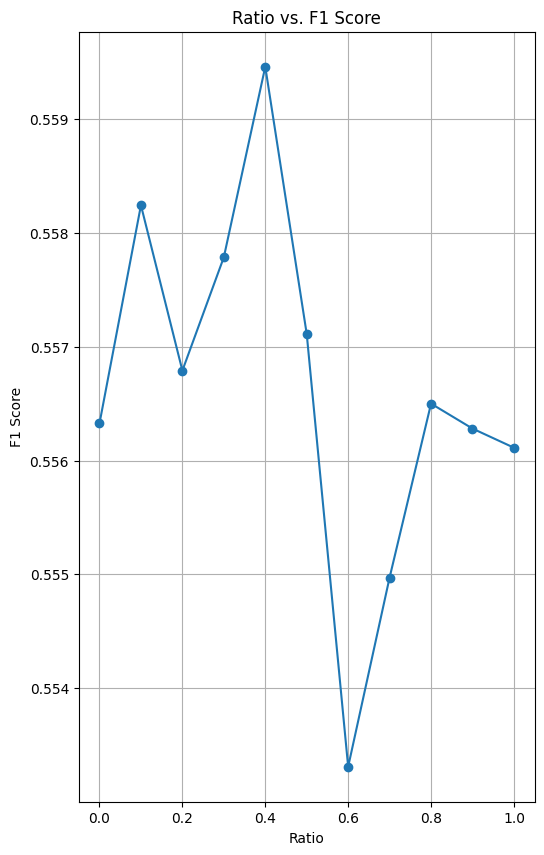

In [11]:
# Plot the ratio vs. F1 score
# plt.figure(figsize=(12, 4))
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.plot(ratios, f1_scores, marker='o')
plt.xlabel('Ratio')
plt.ylabel('F1 Score')
plt.title('Ratio vs. F1 Score')
plt.grid(True)

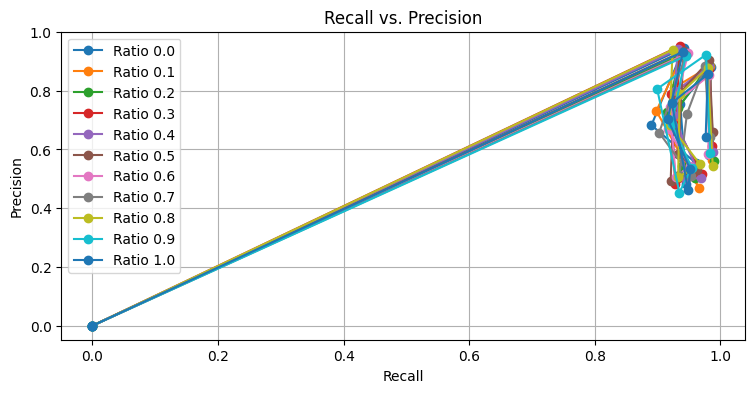

In [12]:
# Plot the recall vs. precision
plt.figure(figsize=(30, 4))
plt.subplot(1, 3, 2)
for i, ratio in enumerate(ratios):
    report = classification_reports[i]
    recall = [report[label]['recall'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    precision = [report[label]['precision'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    plt.plot(recall, precision, marker='o', label=f'Ratio {ratio:.1f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs. Precision')
plt.legend()
plt.grid(True)

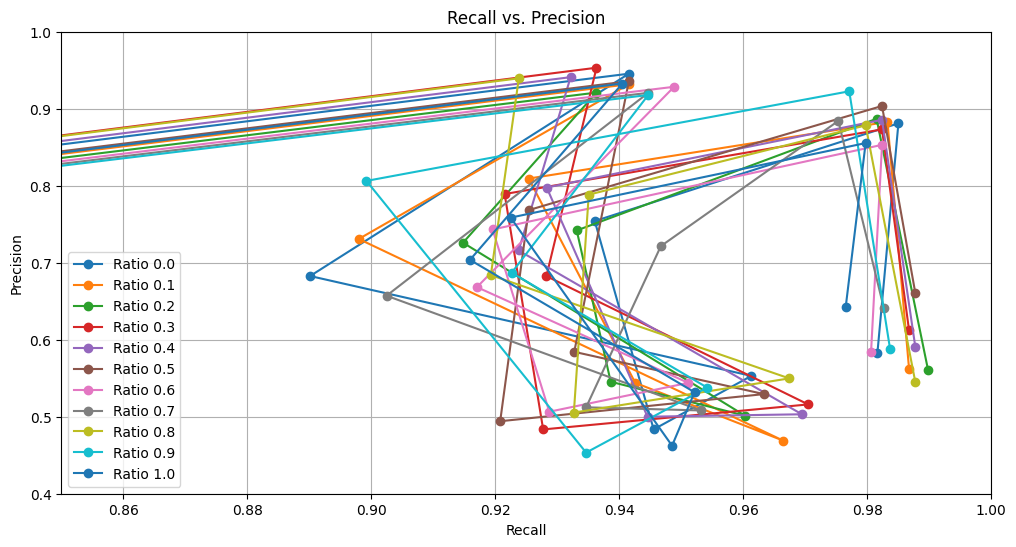

In [13]:
plt.figure(figsize=(12, 6))  # Increase the figure size (adjust as needed)

# Plot the recall vs precision
for i, ratio in enumerate(ratios):
    report = classification_reports[i]
    recall = [report[label]['recall'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    precision = [report[label]['precision'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    plt.plot(recall, precision, marker='o', label=f'Ratio {ratio:.1f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs. Precision')
plt.legend()
plt.grid(True)

plt.xlim(0.85, 1.0)  # Set x-axis limits
plt.ylim(0.4, 1.0)  # Set y-axis limits

plt.show()

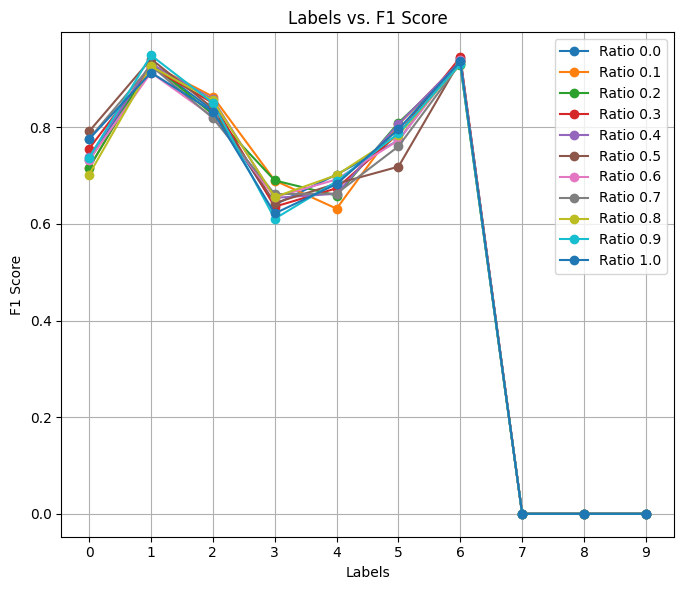

In [14]:
plt.figure(figsize=(20, 6))

# Plot the labels vs. F1 score
plt.subplot(1, 3, 3)
for i, ratio in enumerate(ratios):
    report = classification_reports[i]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    f1_scores = [report[label]['f1-score'] for label in labels]
    plt.plot(labels, f1_scores, marker='o', label=f'Ratio {ratio:.1f}')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('Labels vs. F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()